# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

- контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Данные находятся в папке /datasets/faces/. В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Исследовательский анализ данных

In [1]:
import warnings

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import seaborn as sns
from scipy import stats as st
pd.set_option('display.max_columns', None)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# настройки
warnings.filterwarnings("ignore")

#константы
RANDOM_STATE = 12345

In [2]:
# Универсальная функция для исследования проблем датасета 
def explore_dataset(dataset):
    from IPython.display import display
    
    print('Первые пять строк датасета:')
    display(dataset.head(5))
    
    
    print('')
    print(f'Датасет имеет размер {dataset.shape[0]} строк и {dataset.shape[1]} столбцов.')
    missing_columns = dataset.isna().any()[lambda x: x]
    missing_values = dataset.isnull().sum()/len(dataset)
    missing_values = missing_values[missing_columns.keys()].sort_values(ascending = False)
    if len(missing_columns)>0:
        print(f'Из них {len(missing_columns)} столбцов имеют пропуски в данных.')
        print(f'Это столбцы: ', ', '.join(dataset.isna().any()[lambda x: x].keys()))
        print('')    
        bars = missing_values.plot(kind = 'barh', figsize=(10,round(len(missing_columns)/3)))
        plt.title('Процент пропущенных значений по столбцам')
        for i, v in enumerate(missing_values):
            plt.gca().text(v + 0.005*missing_values.max(), i - 0.1, '{:.2%}'.format(v), color='black')
        plt.show()
        plt.close()
    else:
        print('Пропусков в данных нет')
        
        
    if len(dataset[dataset.duplicated()])>0:
        print(f'В датасете содержится {len(dataset[dataset.duplicated()])} дубликатов')
    else:
        print('В данных не найдено полных дубликатов.')
        
        
    print('')
    print('Столбцы имеют следующие типы данных:')    
    print(dataset.dtypes)
    
    
    print('')
    print('Общая статистика по количественным переменным:')    
    display(dataset.describe())
    print('')
    print('Общая статистика по категориальным переменным:')    
    display(dataset.describe(include=["object", "bool"]))
    
    print('')
    print('Распределение и выбросы данных в количественных переменных:')    
    dataset.plot.box(subplots=True, 
                     layout=(1,len(dataset.select_dtypes(exclude=['object','bool']).columns)), 
                     vert='False',
                     figsize=(2.5*len(dataset.select_dtypes(exclude=['object','bool']).columns),8));
    plt.show()
    plt.close()
    return

In [3]:
data = pd.read_csv('/datasets/faces/labels.csv') 

Первые пять строк датасета:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Датасет имеет размер 7591 строк и 2 столбцов.
Пропусков в данных нет
В данных не найдено полных дубликатов.

Столбцы имеют следующие типы данных:
file_name    object
real_age      int64
dtype: object

Общая статистика по количественным переменным:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000



Общая статистика по категориальным переменным:


,file_name
count,7591
unique,7591
top,007119.jpg
freq,1



Распределение и выбросы данных в количественных переменных:


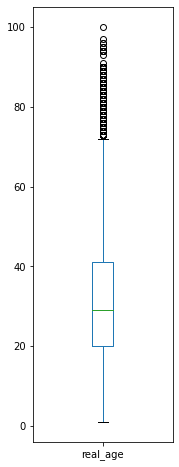

In [4]:
explore_dataset(data)

В датасете содержится 7591 фотографий. Пропусков и дубликатов нет. Посмотрим повнимательней на нашу выборку данных.

Среднее значение возраста на фотографии: 31.2
Медианное значение возраста на фотографии: 29.0
Максимальное значение возраста на фотографии: 100
Минимальное значение возраста на фотографии: 1


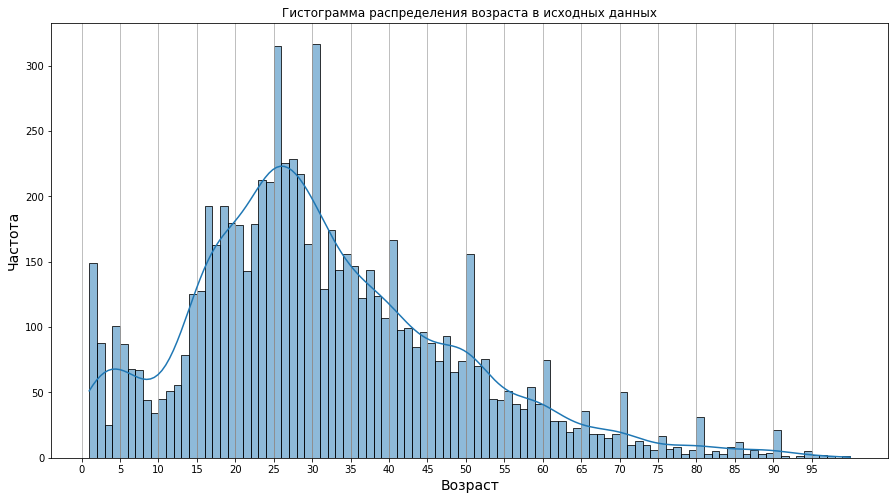

In [5]:
plt.figure(figsize=(15,8))
sns.histplot(data=data,
             x="real_age",
             kde=True, 
             bins=data.real_age.max()-data.real_age.min())

plt.xticks(np.arange(0, 100, step=5))
plt.grid(axis="x")
plt.xlabel("Возраст", size=14)
plt.ylabel("Частота", size=14)
plt.title("Гистограмма распределения возраста в исходных данных")

print('Среднее значение возраста на фотографии:', round(data.real_age.mean(),1))
print('Медианное значение возраста на фотографии:', round(data.real_age.median(),1))
print('Максимальное значение возраста на фотографии:', data.real_age.max())
print('Минимальное значение возраста на фотографии:', data.real_age.min())

Возраст людей на фотографии имеет целочисленное значение в диапазоне от 1 года до 100 лет. Мы построили гистограму частот с количеством интервалов равным количеству уникальных значений возраста на фотографиях. Из гистограммы можно увидеть, что:

- распределение похоже на нормальное с медианным значением - 29 лет, с тем лишь отличием, что в начале распределения, на возрасте 1 года имеется локальный максимум , а затем убывание количества фотографий до 10 лет;

- больше всего фотографий людей в диапазоне от 15 до 35 лет;

- с увеличением возраста после 30 лет количество фотографий плавно уменьшается;

- на графике имеются локальные максимумы на значениях 25, 30 40, 50, 60, 70, 80, 90. Такие всплески числа значений на юбилейных годах, возможно связаны с разметкой изображений. Не всегда возможно определить точный возраст человека в момент фотографирования, возможно разметчики данных определялили диапазон предполагаемых лет и записывали предполагаемый возраст округленный до юбилейных годов. Очевидно, до 25 лет возраст определить проще и с такой проблемой разметчики сталкивались только у взрослых людей.

Проверим данные и разметку на случайной выборке фотографий:

Found 16 validated image filenames.


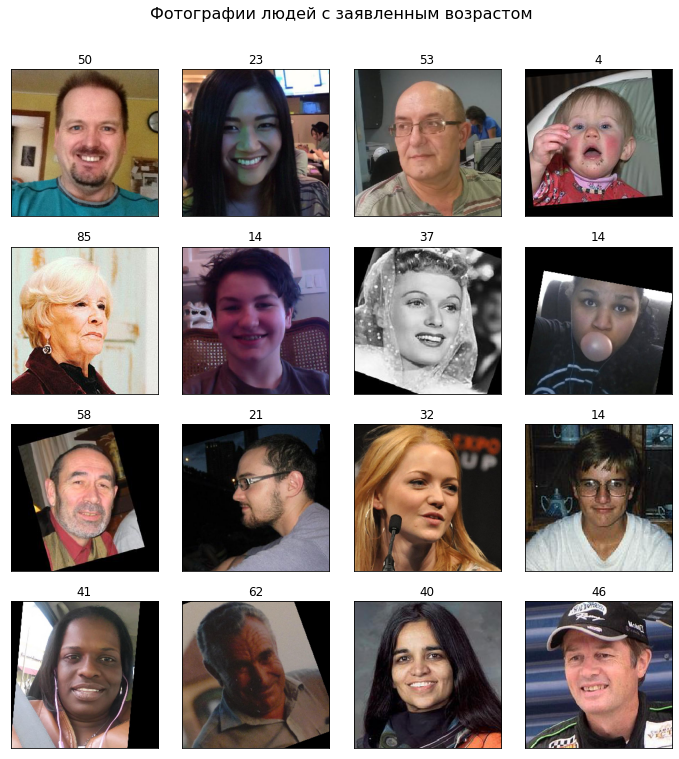

In [6]:
path = "/datasets/faces/final_files"

datagen = ImageDataGenerator(
    rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
    # выберем 16 случайных изображений из датасета
    dataframe=data.sample(16, random_state=RANDOM_STATE),
    directory=path,
    x_col="file_name",
    y_col="real_age",
    # изображения в датасете имеют разный размер, приведем их все к дефолтному (256, 256)
    target_size=(256, 256),
    batch_size=16,
    class_mode="raw",
    seed=RANDOM_STATE
)

features, target = datagen_flow.next()

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    
plt.suptitle('Фотографии людей с заявленным возрастом',  y=1.05,fontsize=16);

Датасет представляет собой фотографии лиц обычных людей и знаменитостей. Фотографии уже предобработаны так, что лица на фото расположены вертикально, однако не всегда анфас, на некоторых фотографиях люди смотрят слегка в профиль. Качество фотографий, их освещенность тоже различаются. Разметка на первый взгляд не вызывает нареканий. Указанный возраст вполне может быть настоящим.

### Вывод по разделу

Исходя из поставленными перед моделью задачами, а именно :

- определение возрастной группы для продвижения товаров;

- определение возрастной группы при продаже алкоголя, 

можно сделать следующие предположения:

- Данных вполне достаточно чтобы разбить покупателей на крупные возрастные группы. Те возраста где данных мало, неплохо объединяются в более крупные группы схожие по покупательским интересам. В промежутке от 15 до 35 лет, когда покупательские интересы меняются куда чаще, данных больше всего.
- Для задачи с продажей алкоголя нам потребуется высокая точность модели, чтобы можно было с уверенностью сказать что человеку не 17 а уже, допустим 18 лет, что не всегда под силу и для человеческого разума.

Что касаается увеличения выборки данных аугментацией, то тут лучше быть аккуратными. Искажения лиц может сильно повлиять на визуальный возраст человека. Различные повороты головы тоже не вписываются концепцию модели, нам надо не определить наличие лица на картинки, а найти черты которые определяют возраст, для этого модели надо видеть лица расположенные плюс минус одинаково. Таким образом единственный вид аугментации который выглядит адекватно в данной задаче - это зеркальное отражение по горизонтали. 

## Обучение модели

Мы обучили модель на GPU, ее код и результат работы выглядят следующим образом:

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd


def load_train(path):
    
    df = pd.read_csv(path+'labels.csv') 
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True,
    )


    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(256, 256),
        batch_size=16,
        class_mode="raw",
        subset='training',
        shuffle=True,
        seed=12345
    )

    return train_datagen_flow

def load_test(path):

    df = pd.read_csv(path+'labels.csv') 
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + 'final_files',
        x_col="file_name",
        y_col="real_age",
        target_size=(256, 256),
        batch_size=16,
        class_mode="raw",
        subset='validation',
        shuffle=True,
        seed=12345)
        
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=124,
                    activation='relu'))
    model.add(Dense(units=84,
                    activation='relu'))
    model.add(Dense(1, activation='relu'))  
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])
    print(model.summary())
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):


    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 124)               254076    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 85        
=================================================================
Total params: 23,852,373
Trainable params: 23,799,253
Non-trainable params: 53,120
_________________________________________________________________
None
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-07-12 08:12:41.983374: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-12 08:12:42.322278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 58s - loss: 195.0871 - mean_absolute_error: 10.1989 - val_loss: 566.3990 - val_mean_absolute_error: 18.7255
Epoch 2/10
356/356 - 65s - loss: 81.7148 - mean_absolute_error: 6.8836 - val_loss: 150.5106 - val_mean_absolute_error: 9.1523
Epoch 3/10
356/356 - 52s - loss: 56.6470 - mean_absolute_error: 5.7731 - val_loss: 79.1588 - val_mean_absolute_error: 6.7450
Epoch 4/10
356/356 - 46s - loss: 42.3611 - mean_absolute_error: 4.9820 - val_loss: 83.6092 - val_mean_absolute_error: 6.9333
Epoch 5/10
356/356 - 44s - loss: 28.7905 - mean_absolute_error: 4.1157 - val_loss: 67.0827 - val_mean_absolute_error: 5.9484
Epoch 6/10
356/356 - 42s - loss: 21.0990 - mean_absolute_error: 3.5386 - val_loss: 65.0283 - val_mean_absolute_error: 6.1080
Epoch 7/10
356/356 - 41s - loss: 17.3058 - mean_absolute_error: 3.1535 - val_loss: 64.1461 - val_mean_absolute_error: 6.0393
Epoch 8/10
356/356 - 42s - loss: 14.2726 - mean_absolute_error: 2.8879 - val_loss: 63.3623 - val_mean_absolute_error: 5.9342
Epoch 9/10
356/356 - 42s - loss: 13.4462 - mean_absolute_error: 2.7800 - val_loss: 62.4937 - val_mean_absolute_error: 5.9604
Epoch 10/10
356/356 - 43s - loss: 13.1510 - mean_absolute_error: 2.7371 - val_loss: 60.7725 - val_mean_absolute_error: 5.7588

119/119 - 10s - loss: 60.7725 - mean_absolute_error: 5.7588
Test MAE: 5.7588



```

## Анализ обученной модели

### Описание модели

**Подготовка данных**

Для обучения и тестирования модели мы разбили выборку на обучающую и тестовую в соотношении 3 к 1. Загрузка данных осуществляется методом *flow_from_dataframe* класса *ImageDataGenerator()*. Данные были нормированы, приведены к единому размеру 256 на 256 пикселей, а для обучающей выборки применена аугментация - отражение по горизонтали. Для того чтобы данные обучающей выборки не попали в тестовую мы задали одинаковый параметр seed.

**Структура модели**

За основу нашей модели мы взяли сверточную нейронную сеть ResNet50 с весами обученными на датасете ImageNet в качестве начальных. В таблице ниже описание модели по слоям:
```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 124)               254076    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 85        
=================================================================
Total params: 23,852,373
Trainable params: 23,799,253
Non-trainable params: 53,120
```

Таким образом мы взяли за основу модель ResNet50 без верхушки и надстроили вместо нее несколько полносвязных слоев:

- слой с 124 нейронами и функцией активации ReLU;
- слой с 84 нейронами и функцией активации ReLU;
- слой с 1 нейроном и функцией активации ReLU, который на выходе дает предполагаемый возраст человека на фотографии;

Функция потерь в модели - MSE, метрика - MAE, а оптимизатор Adam с шагом обучения 0.0001 

**Обучение модели**

Модель обучалась в течении 10 эпох с размером батча - 16. За 10 эпох нам удалось добиться снижения метрики MAE на тестовой выборки до 5.7588.

# Вывод

Перед нами стояла задача построить модель, которая по фотографии определит приблизительный возраст человека. Эта информация будет использоваться для:

- анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;

- контроля добросовестности кассиров при продаже алкоголя.

В нашем распоряжении был датасет с 7591 фотографиями лиц разных возрастов от 1 года до 100 лет. Анализ данных показал, что распределение фотографий по возрастам не равномерное, максимум распределения приходится на возраст около 30 лет. При этом наблюдаются неестественные пики на юбилейных возростах, таких как 25, 30, 40, 50 и т.д., что говорит о некоторых допущениях при разметке фотографий и возможных неточностях в определении возраста. Этот фактор может искажать результаты полученные моделью.

Нами была обучена модель сверточной нейронной сети основанная на ResNet50. Нам удалось добиться метрики MAE на тестовой выборке равной 5.8 лет. Таким образом модель выполняет поставленную перед нами задачу предсказывать возраст по фотографии с метрикой MAE меньше 8. 

Данная модель подходит для задач распределения покупателей в различные возрастные группы. Однако, стоит отметить, что данная модель, не способна выполнять задачу контроля при продаже алкоголя, поскольку заявленная точность не позволяет с уверенностью отнести покупателя к группе совершеннолетних людей в диапазоне возраста 12 - 24 года. А это именно та возрастная категория, которая  требует особого контроля при продаже алкоголя. 